In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matlab_lib import loadmat

In [2]:
matDict = {
    'left' : loadmat("../data/exampledata_left.mat")['input_field1'],
    'right' : loadmat("../data/exampledata_right.mat")['input_field2']
}

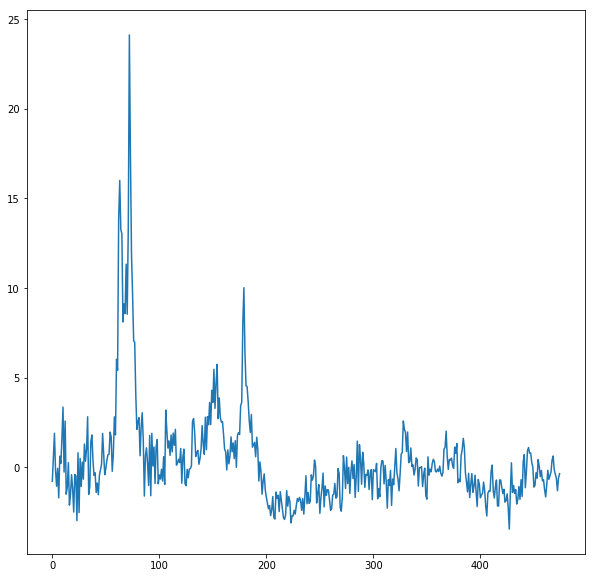

In [3]:
plt.figure(figsize=(10,10))
plt.plot(matDict['left'][3,:5].flatten())
plt.show()

#### Investigate Distribution

In [7]:
from scipy.optimize import minimize, Bounds

nCell, nTrial, nTime = matDict['left'].shape
cellDataFlat =  matDict['left'].reshape((nCell, nTrial * nTime))
cellDataFlat -= np.min(cellDataFlat)  # Add constant to ensure all cells have positive activity

nParam = nCell + nTrial * nTime

# Now attempt to fit baseline to the whole neuron set
def L2(x):
    alpha = x[:nCell]
    base = x[nCell:]
    return np.linalg.norm(cellDataFlat - np.outer(alpha, base))**2

def jacL2(x):
    alpha = x[:nCell]
    base = x[nCell:]
    L = cellDataFlat - np.outer(alpha, base)
    rez = np.zeros(nParam)
    rez[:nCell] = -2*L.dot(base)
    rez[nCell:] = -2*alpha.dot(L)
    return rez
    
x0 = np.random.uniform(1,5, nParam)

nonNegativeBound = Bounds(np.zeros(nParam), np.full(nParam, np.inf))

res = minimize(L2, x0, method='L-BFGS-B', bounds=nonNegativeBound, jac=jacL2)
print("Did we succeed?", res.success)

Did we succeed? True


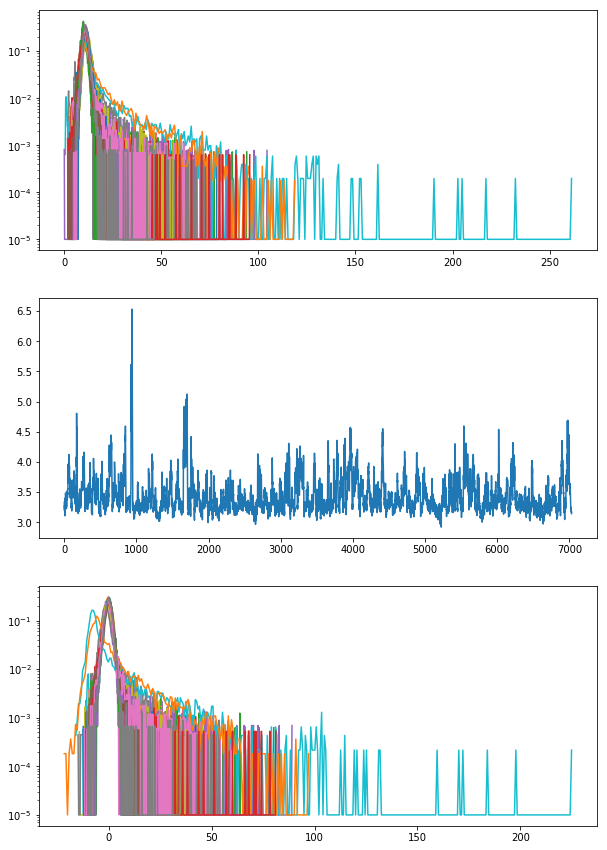

In [13]:
def addHistCurve(ax, data):
    y,x = np.histogram(data, bins='auto', density=True)
    y[y == 0] = 1.0E-5
    ax.semilogy(x[:-1], y)
    
alpha = res.x[:nCell]
base = res.x[nCell:]
cellDataFlatNoBase = cellDataFlat - np.outer(alpha, base)

fig, ax = plt.subplots(nrows=3, figsize=(10, 15))
ax[0].set_title("Cell activity distribution")
ax[1].set_title("Fitted baseline")
ax[2].set_title("Cell activity distribution after baseline subtraction")
ax[1].plot(base)
for i in range(nCell):
    addHistCurve(ax[0], cellDataFlat[i])
    addHistCurve(ax[2], cellDataFlatNoBase[i])
plt.show()

##### Investigate baseline

The neuronal baseline will be computed as the n-th lowest percentile. User can validate the baseline selection by observing histograms of a few example cells 

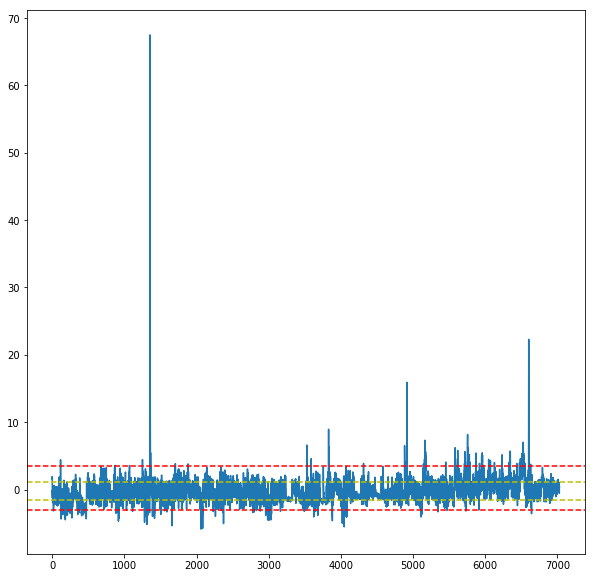

In [6]:
nCell, nTrial, nTime = matDict['left'].shape

plt.figure(figsize=(10,10))
dataThis = matDict['left'][0].flatten()
cut1 = np.percentile(dataThis, 2.3)
cut2 = np.percentile(dataThis, 15.9)
cut3 = np.percentile(dataThis, 84.1)
cut4 = np.percentile(dataThis, 97.7)
plt.plot(dataThis)
plt.axhline(y=cut1, color='r', linestyle='--')
plt.axhline(y=cut2, color='y', linestyle='--')
plt.axhline(y=cut3, color='y', linestyle='--')
plt.axhline(y=cut4, color='r', linestyle='--')
plt.show()

**Data looks wiggly, maybe there is something in the spectrum**

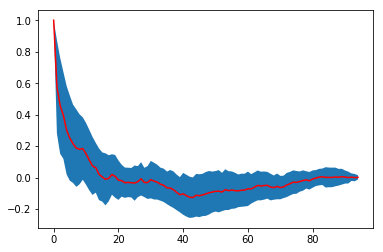

In [7]:
def autocorr(x):
    nX = x.shape[0]
    mu, s2 = np.mean(x), np.var(x)
    return np.correlate(x-mu,x-mu,'full')[nX-1:]/s2/nX

dataCell0 = matDict['left'][:, 0, :]
ac2D = [autocorr(tr) for tr in dataCell0]
ac1Dmu = np.mean(ac2D, axis=0)
ac1Dstd = np.std(ac2D, axis=0)

plt.figure()
t = np.arange(len(ac1Dmu))
plt.fill_between(t, ac1Dmu-ac1Dstd, ac1Dmu+ac1Dstd)
plt.plot(t, ac1Dmu, 'r')
plt.show()

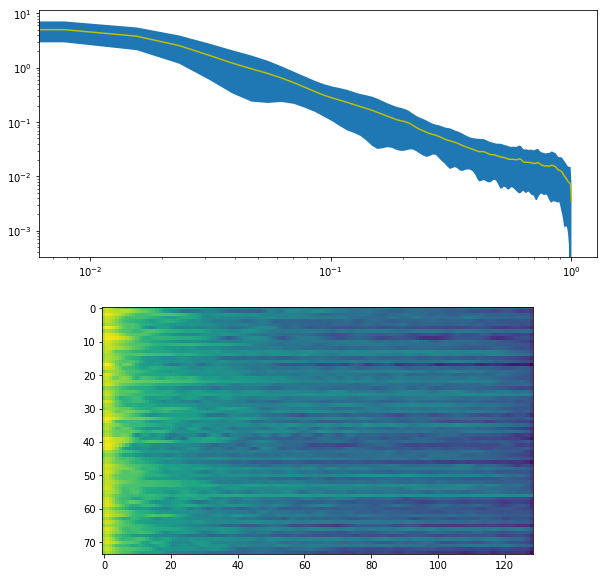

In [8]:
nTrial, nCell, nTime = matDict['left'].shape
zScored = np.copy(matDict['left'])
for i in range(nCell):
    zScored[:, i, :] -= np.mean(zScored[:, i, :])
    zScored[:, i, :] /= np.std(zScored[:, i, :]) # / np.sqrt(nTrial*nTime)

psdArr = np.zeros((nCell, 129))


for iCell in range(nCell):
    psd = np.array([plt.mlab.psd(y) for y in zScored[:, iCell, :]]).transpose((1, 0, 2))
    psdx = psd[1,0]
    psdArr[iCell] = np.mean(psd[0], axis=0)

psdMu = np.mean(psdArr, axis=0)
psdStd = np.std(psdArr, axis=0)
fig, ax = plt.subplots(nrows=2, figsize=(10,10))
ax[0].fill_between(psdx, psdMu-psdStd, psdMu+psdStd)
ax[0].loglog(psdx, psdMu, 'y')
ax[1].imshow(np.log(psdArr))
plt.show()